In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import holidays
from datetime import datetime
import seaborn as sns
import tensorflow as tf
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# 데이터 전처리 함수

In [2]:
def preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df_gbline = df[df['주운행선'] == '경부선'].copy()
    df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m')
    # Lagged Variable
    df_gbline['승차인원수_T1'] = df_gbline['승차인원수'].shift(1)
    df_gbline['승차인원수_T2'] = df_gbline['승차인원수'].shift(2)
    df_gbline.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)

    train_data = df_gbline[(df_gbline['운행년월'] >= '2015-01-01') & (df_gbline['운행년월'] <= '2023-03-31')]
    val_data = df_gbline[(df_gbline['운행년월'] >= '2023-04-01') & (df_gbline['운행년월'] <= '2024-03-31')]

    features = ['KOSPIV', '공휴일수', '평일수', '주말수', '명절수', '승차인원수_T1', '승차인원수_T2']

    X_train = train_data[features].dropna()
    Y_train = train_data.loc[X_train.index, '승차인원수']
    X_val = val_data[features].dropna()
    Y_val = val_data.loc[X_val.index, '승차인원수']

    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

    return X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data

# 모델 훈련 및 평가 함수

In [3]:
#랜덤포레스트
def tune_and_evaluate_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 5, 30, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'max_features': hp.uniform('max_features', 0.1, 1.0),
        'bootstrap': hp.choice('bootstrap', [True, False])
    }

    def objective(space):
        clf = RandomForestRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            min_samples_split=int(space['min_samples_split']),
            min_samples_leaf=int(space['min_samples_leaf']),
            max_features=space['max_features'],
            bootstrap=space['bootstrap'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = RandomForestRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        min_samples_split=int(best_hyperparams['min_samples_split']),
        min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
        max_features=best_hyperparams['max_features'],
        bootstrap=best_hyperparams['bootstrap'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#XGB
def tune_and_evaluate_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('subsample', 0.7, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1.0)
    }

    def objective(space):
        clf = xgb.XGBRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            learning_rate=space['learning_rate'],
            subsample=space['subsample'],
            colsample_bytree=space['colsample_bytree'],
            gamma=space['gamma'],
            reg_alpha=space['reg_alpha'],
            reg_lambda=space['reg_lambda'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = xgb.XGBRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        learning_rate=best_hyperparams['learning_rate'],
        subsample=best_hyperparams['subsample'],
        colsample_bytree=best_hyperparams['colsample_bytree'],
        gamma=best_hyperparams['gamma'],
        reg_alpha=best_hyperparams['reg_alpha'],
        reg_lambda=best_hyperparams['reg_lambda'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#LightGBM
def train_and_evaluate_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val):
    # LightGBM 모델 초기화
    lgb_model = lgb.LGBMRegressor(random_state=0)

    # 모델 훈련
    lgb_model.fit(X_train_scaled, Y_train)

    # 훈련 데이터 예측
    Y_train_pred_lgb = lgb_model.predict(X_train_scaled)
    train_r_squared_lgb = r2_score(Y_train, Y_train_pred_lgb)
    train_mae_lgb = mean_absolute_error(Y_train, Y_train_pred_lgb)
    train_mse_lgb = mean_squared_error(Y_train, Y_train_pred_lgb)
    train_mape_lgb = np.mean(np.abs((Y_train - Y_train_pred_lgb) / Y_train)) * 100

    # 검증 데이터 예측
    Y_val_pred_lgb = lgb_model.predict(X_val_scaled)
    val_r_squared_lgb = r2_score(Y_val, Y_val_pred_lgb)
    val_mae_lgb = mean_absolute_error(Y_val, Y_val_pred_lgb)
    val_mse_lgb = mean_squared_error(Y_val, Y_val_pred_lgb)
    val_mape_lgb = np.mean(np.abs((Y_val - Y_val_pred_lgb) / Y_val)) * 100

    results = {
        'train_metrics': {
            'r_squared': train_r_squared_lgb,
            'mae': train_mae_lgb,
            'mse': train_mse_lgb,
            'mape': train_mape_lgb
        },
        'val_metrics': {
            'r_squared': val_r_squared_lgb,
            'mae': val_mae_lgb,
            'mse': val_mse_lgb,
            'mape': val_mape_lgb
        }
    }
    return lgb_model, results

# 시각화 함수

In [4]:
def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

# RandomForest

100%|██████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11trial/s, best loss: 370985.04497126426]
The best hyperparameters :  

{'bootstrap': 1, 'max_depth': 27.0, 'max_features': 0.893706528465255, 'min_samples_leaf': 2.0, 'min_samples_split': 2.0, 'n_estimators': 290.0}
Random Forest(Train):
R-squared: 0.93
MAE: 111946.99
MSE: 30558769161.06
MAPE: 5.15%

Random Forest(Val):
R-squared: -0.17
MAE: 417791.53
MSE: 1122149250570.68
MAPE: 7.72%


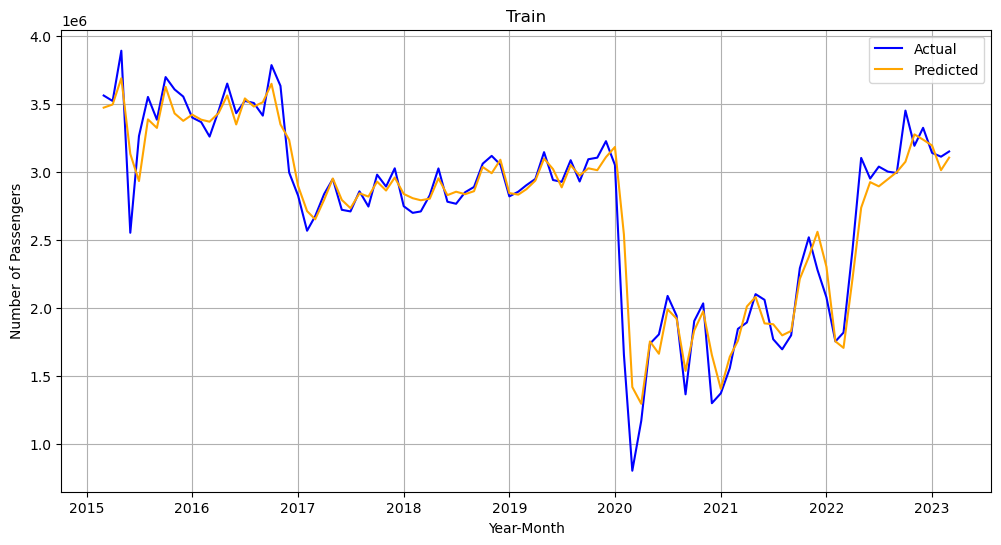

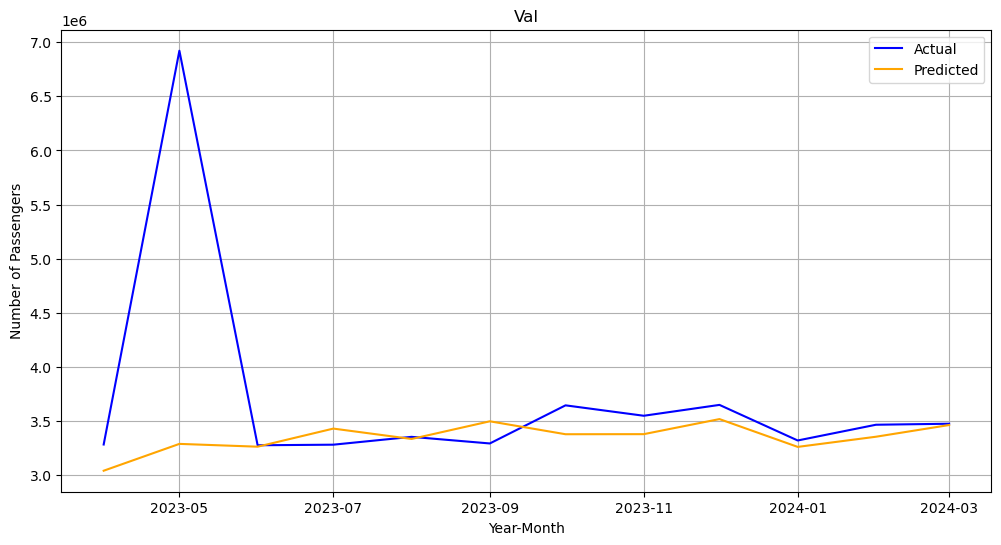

In [5]:
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240615.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# RandomForest 모델 평가
best_rf_model, rf_results = tune_and_evaluate_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
print("The best hyperparameters : ", "\n")
print(rf_results['best_hyperparams'])

print('Random Forest(Train):')
print(f"R-squared: {rf_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {rf_results['train_metrics']['mae']:.2f}")
print(f"MSE: {rf_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {rf_results['train_metrics']['mape']:.2f}%")
print()
print('Random Forest(Val):')
print(f"R-squared: {rf_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {rf_results['val_metrics']['mae']:.2f}")
print(f"MSE: {rf_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {rf_results['val_metrics']['mape']:.2f}%")

Y_train_pred_rf = best_rf_model.predict(X_train_scaled)
Y_val_pred_rf = best_rf_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_rf, Y_val, Y_val_pred_rf)
#{'bootstrap': 1, 'max_depth': 19.0, 'max_features': 0.9675041555090511, 'min_samples_leaf': 2.0, 'min_samples_split': 7.0, 'n_estimators': 150.0}

# XGBoost

100%|███████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23trial/s, best loss: 405608.3541666667]
The best hyperparameters :  

{'colsample_bytree': 0.8967331123205029, 'gamma': 0.20260945454100854, 'learning_rate': 0.13085690758815594, 'max_depth': 4.0, 'n_estimators': 210.0, 'reg_alpha': 0.7217811373531764, 'reg_lambda': 0.4711322769253773, 'subsample': 0.798103901293553}
XGBoost(Train):
R-squared: 1.00
MAE: 1751.81
MSE: 4537631.67
MAPE: 0.07%

XGBoost(Val):
R-squared: -0.14
MAE: 405608.35
MSE: 1086649566899.55
MAPE: 7.58%


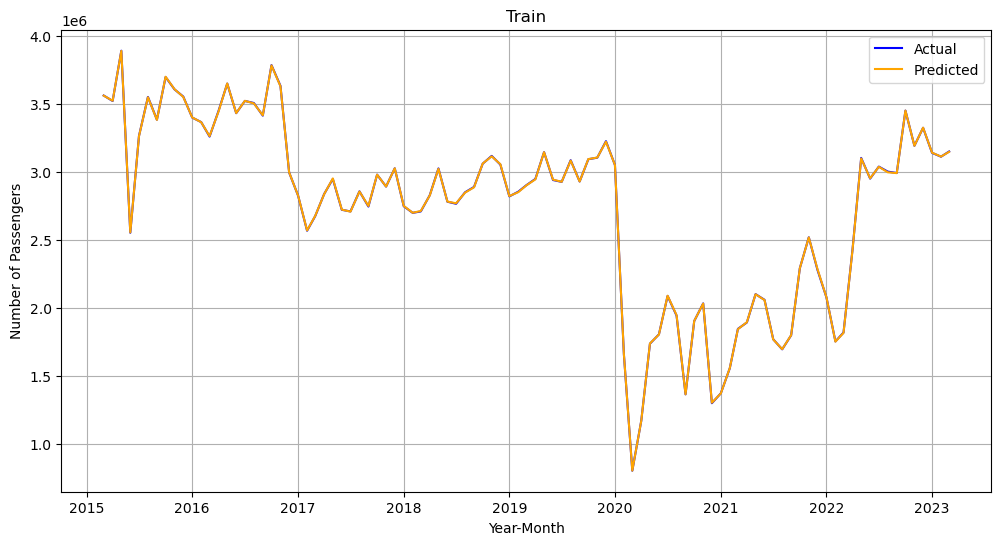

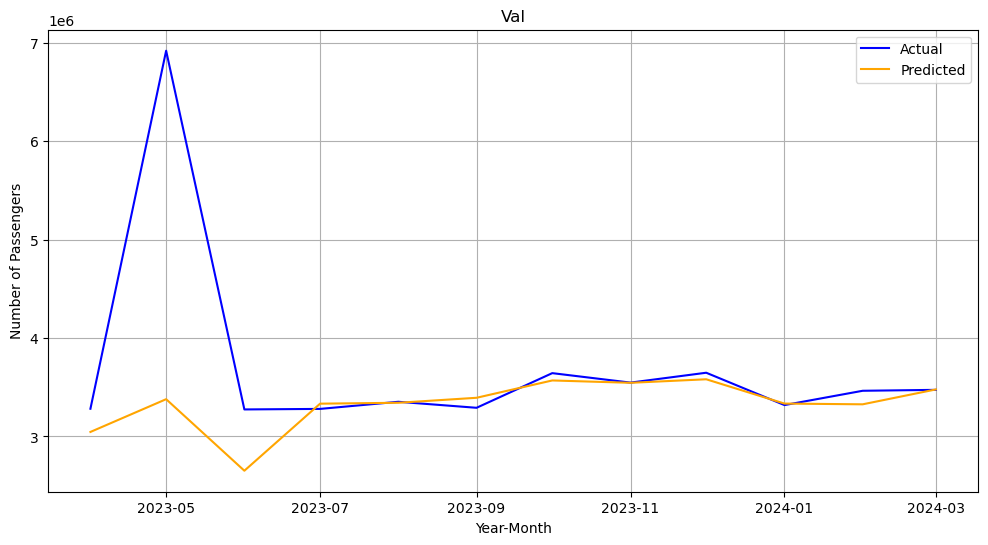

In [6]:
# XGBoost 모델 평가
best_xgb_model, xgb_results = tune_and_evaluate_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
print("The best hyperparameters : ", "\n")
print(xgb_results['best_hyperparams'])

print('XGBoost(Train):')
print(f"R-squared: {xgb_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {xgb_results['train_metrics']['mae']:.2f}")
print(f"MSE: {xgb_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {xgb_results['train_metrics']['mape']:.2f}%")
print()
print('XGBoost(Val):')
print(f"R-squared: {xgb_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {xgb_results['val_metrics']['mae']:.2f}")
print(f"MSE: {xgb_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {xgb_results['val_metrics']['mape']:.2f}%")

Y_train_pred_xgb = best_xgb_model.predict(X_train_scaled)
Y_val_pred_xgb = best_xgb_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_xgb, Y_val, Y_val_pred_xgb)
#{'colsample_bytree': 0.8922607113389976, 'gamma': 0.29202225637784096, 'learning_rate': 0.10486928608249282, 'max_depth': 6.0, 'n_estimators': 280.0, 'reg_alpha': 0.9413775711280722, 'reg_lambda': 0.8990091066271554, 'subsample': 0.8712113355918811}

# LightXGM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 6
[LightGBM] [Info] Start training from score 2752700.144330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

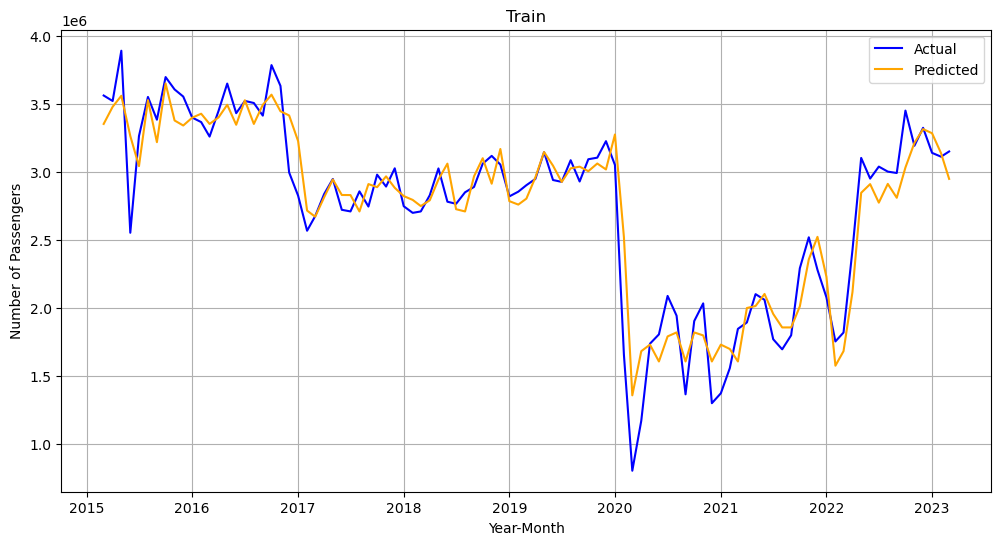

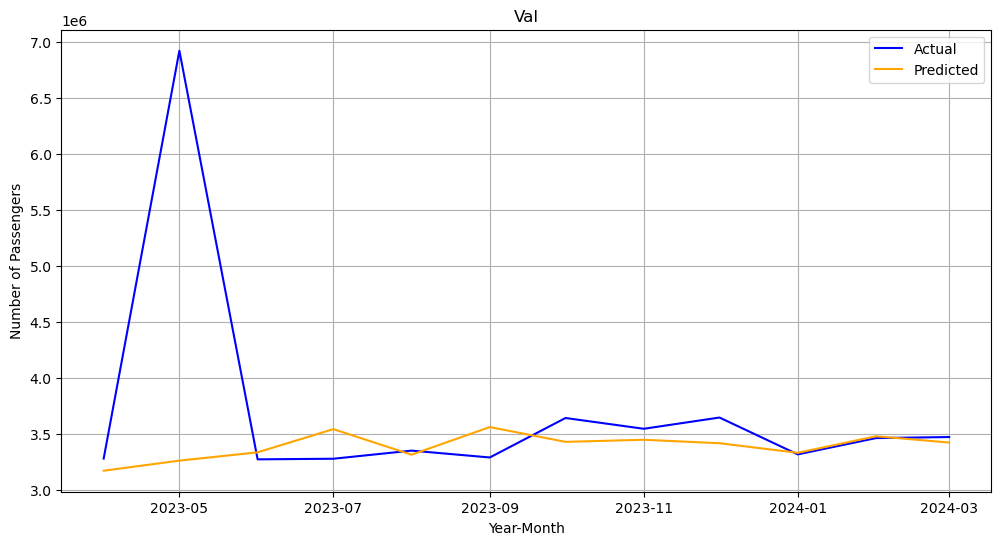

In [19]:
# LightGBM 모델 훈련 및 평가
best_lgb_model, lgb_results = train_and_evaluate_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val)
print("LightGBM(Train):")
print(f"R-squared: {lgb_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {lgb_results['train_metrics']['mae']:.2f}")
print(f"MSE: {lgb_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {lgb_results['train_metrics']['mape']:.2f}%")
print()
print("LightGBM(Val):")
print(f"R-squared: {lgb_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {lgb_results['val_metrics']['mae']:.2f}")
print(f"MSE: {lgb_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {lgb_results['val_metrics']['mape']:.2f}%")

Y_train_pred_lgb = best_lgb_model.predict(X_train_scaled)
Y_val_pred_lgb = best_lgb_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_lgb, Y_val, Y_val_pred_lgb)


# LSTM

Epoch 1/100
2/2 - 25s - 13s/step - loss: 0.4341 - val_loss: 0.0747
Epoch 2/100
2/2 - 0s - 149ms/step - loss: 0.3664 - val_loss: 0.0705
Epoch 3/100
2/2 - 0s - 141ms/step - loss: 0.2891 - val_loss: 0.0838
Epoch 4/100
2/2 - 0s - 148ms/step - loss: 0.2001 - val_loss: 0.1500
Epoch 5/100
2/2 - 0s - 149ms/step - loss: 0.1074 - val_loss: 0.3694
Epoch 6/100
2/2 - 0s - 192ms/step - loss: 0.0730 - val_loss: 0.7640
Epoch 7/100
2/2 - 0s - 141ms/step - loss: 0.1286 - val_loss: 0.7154
Epoch 8/100
2/2 - 0s - 151ms/step - loss: 0.0978 - val_loss: 0.4818
Epoch 9/100
2/2 - 0s - 136ms/step - loss: 0.0614 - val_loss: 0.3215
Epoch 10/100
2/2 - 0s - 146ms/step - loss: 0.0658 - val_loss: 0.2458
Epoch 11/100
2/2 - 0s - 128ms/step - loss: 0.0750 - val_loss: 0.2198
Epoch 12/100
2/2 - 0s - 140ms/step - loss: 0.0780 - val_loss: 0.2236
1/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000

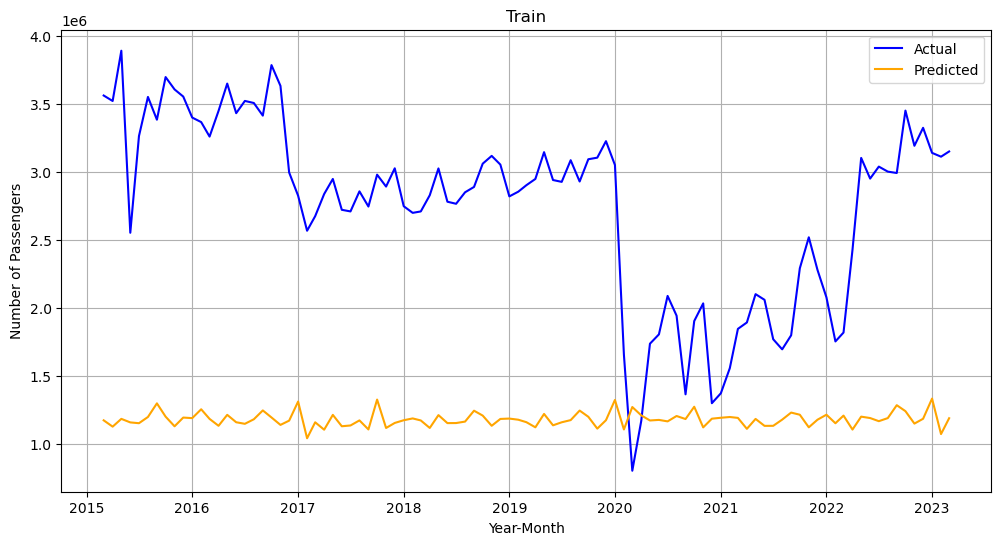

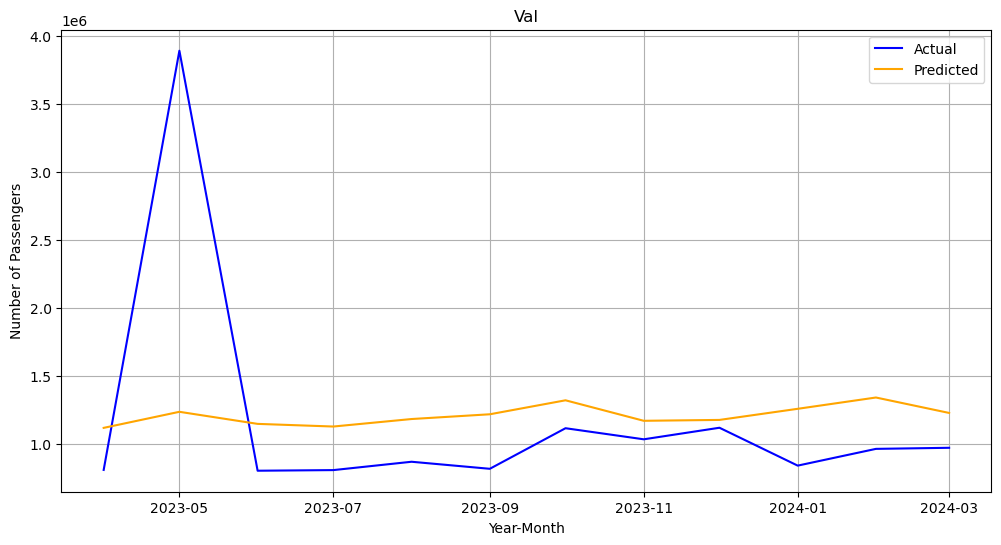

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

def preprocess_for_lstm(X, Y):
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1))

    X_reshaped = X_scaled.reshape((X.shape[0], X.shape[1], 1))
    Y_reshaped = Y_scaled.reshape((Y.shape[0], 1))
    
    return X_reshaped, Y_reshaped, scaler_X, scaler_Y

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def tune_and_evaluate_lstm(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
    input_shape = (X_train.shape[1], X_train.shape[2])
    lstm_model = create_lstm_model(input_shape)

    history = lstm_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                             validation_data=(X_val, Y_val), verbose=2, 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    Y_train_pred = lstm_model.predict(X_train)
    Y_val_pred = lstm_model.predict(X_val)

    return lstm_model, Y_train_pred, Y_val_pred, history

def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240615.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# 데이터 전처리 (LSTM용)
X_train_lstm, Y_train_lstm, scaler_X, scaler_Y = preprocess_for_lstm(X_train_scaled, Y_train)
X_val_lstm, Y_val_lstm, _, _ = preprocess_for_lstm(X_val_scaled, Y_val)

# LSTM 모델 평가
best_lstm_model, Y_train_pred_lstm, Y_val_pred_lstm, history = tune_and_evaluate_lstm(X_train_lstm, Y_train_lstm, X_val_lstm, Y_val_lstm, epochs=100, batch_size=64)

# 역변환 (Inverse Transform)하여 원래 스케일로 변환
Y_train_pred_lstm = scaler_Y.inverse_transform(Y_train_pred_lstm)
Y_val_pred_lstm = scaler_Y.inverse_transform(Y_val_pred_lstm)
Y_train_lstm = scaler_Y.inverse_transform(Y_train_lstm)
Y_val_lstm = scaler_Y.inverse_transform(Y_val_lstm)

# 성능 지표 계산
train_r_squared = r2_score(Y_train_lstm, Y_train_pred_lstm)
train_mae = mean_absolute_error(Y_train_lstm, Y_train_pred_lstm)
train_mse = mean_squared_error(Y_train_lstm, Y_train_pred_lstm)
train_mape = np.mean(np.abs((Y_train_lstm - Y_train_pred_lstm) / Y_train_lstm)) * 100

val_r_squared = r2_score(Y_val_lstm, Y_val_pred_lstm)
val_mae = mean_absolute_error(Y_val_lstm, Y_val_pred_lstm)
val_mse = mean_squared_error(Y_val_lstm, Y_val_pred_lstm)
val_mape = np.mean(np.abs((Y_val_lstm - Y_val_pred_lstm) / Y_val_lstm)) * 100

results = {
    'train_metrics': {
        'r_squared': train_r_squared,
        'mae': train_mae,
        'mse': train_mse,
        'mape': train_mape
    },
    'val_metrics': {
        'r_squared': val_r_squared,
        'mae': val_mae,
        'mse': val_mse,
        'mape': val_mape
    }
}

print('LSTM(Train):')
print(f"R-squared: {results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {results['train_metrics']['mae']:.2f}")
print(f"MSE: {results['train_metrics']['mse']:.2f}")
print(f"MAPE: {results['train_metrics']['mape']:.2f}%")
print()
print('LSTM(Val):')
print(f"R-squared: {results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {results['val_metrics']['mae']:.2f}")
print(f"MSE: {results['val_metrics']['mse']:.2f}")
print(f"MAPE: {results['val_metrics']['mape']:.2f}%")

plot_results(train_data, val_data, Y_train_lstm, Y_train_pred_lstm, Y_val_lstm, Y_val_pred_lstm)


# CNN

Epoch 1/100
2/2 - 8s - 4s/step - loss: 0.4177 - val_loss: 0.0715
Epoch 2/100
2/2 - 0s - 111ms/step - loss: 0.2759 - val_loss: 0.0816
Epoch 3/100
2/2 - 0s - 163ms/step - loss: 0.1784 - val_loss: 0.1251
Epoch 4/100
2/2 - 0s - 113ms/step - loss: 0.1016 - val_loss: 0.2057
Epoch 5/100
2/2 - 0s - 113ms/step - loss: 0.0593 - val_loss: 0.3208
Epoch 6/100
2/2 - 0s - 163ms/step - loss: 0.0482 - val_loss: 0.4430
Epoch 7/100
2/2 - 0s - 118ms/step - loss: 0.0799 - val_loss: 0.4950
Epoch 8/100
2/2 - 0s - 173ms/step - loss: 0.0800 - val_loss: 0.4745
Epoch 9/100
2/2 - 0s - 111ms/step - loss: 0.0792 - val_loss: 0.4108
Epoch 10/100
2/2 - 0s - 107ms/step - loss: 0.0697 - val_loss: 0.3370
Epoch 11/100
2/2 - 0s - 119ms/step - loss: 0.0466 - val_loss: 0.2755
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
CNN(Train):
R-squared: -5.50
MAE: 1594700.53
MSE: 2918412859003.48
MAPE: 55.18%

CNN(Val):
R-squared: 0.01
MAE: 426371.55
MSE: 684041558060.66
MAPE: 28.98%


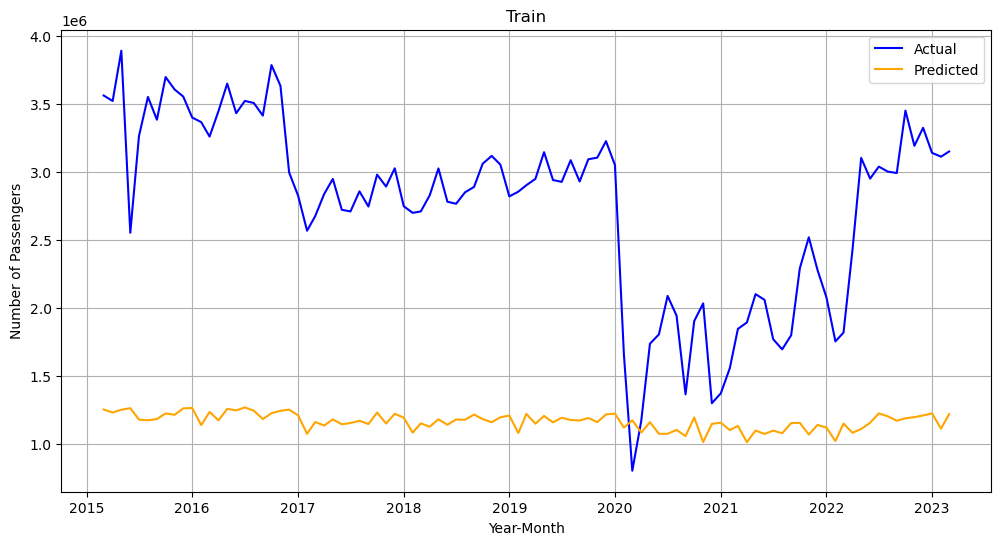

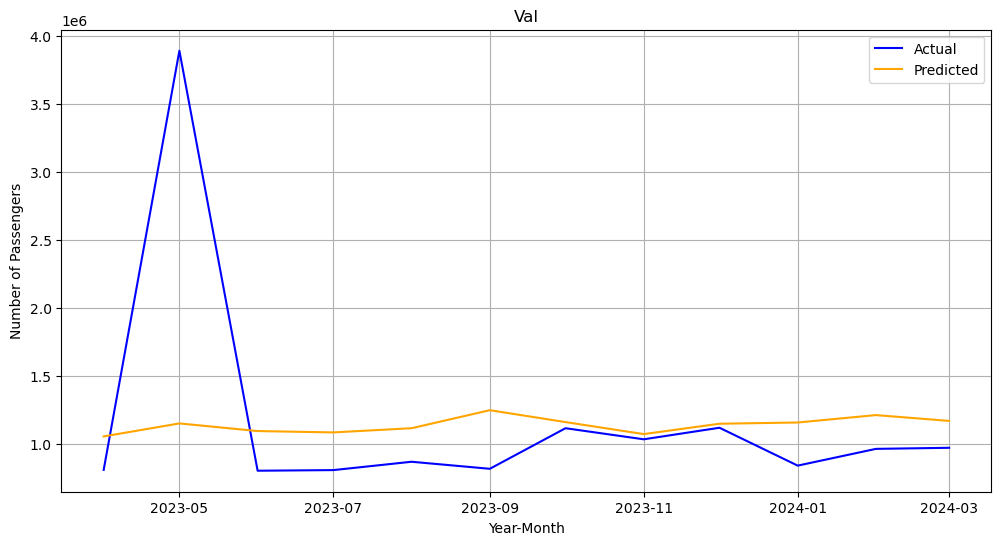

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

def preprocess_for_cnn(X, Y):
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1))

    X_reshaped = X_scaled.reshape((X.shape[0], X.shape[1], 1))
    Y_reshaped = Y_scaled.reshape((Y.shape[0], 1))
    
    return X_reshaped, Y_reshaped, scaler_X, scaler_Y

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def tune_and_evaluate_cnn(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
    input_shape = (X_train.shape[1], X_train.shape[2])
    cnn_model = create_cnn_model(input_shape)

    history = cnn_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                            validation_data=(X_val, Y_val), verbose=2, 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    Y_train_pred = cnn_model.predict(X_train)
    Y_val_pred = cnn_model.predict(X_val)

    return cnn_model, Y_train_pred, Y_val_pred, history

def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240615.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# 데이터 전처리 (CNN용)
X_train_cnn, Y_train_cnn, scaler_X, scaler_Y = preprocess_for_cnn(X_train_scaled, Y_train)
X_val_cnn, Y_val_cnn, _, _ = preprocess_for_cnn(X_val_scaled, Y_val)

# CNN 모델 평가
best_cnn_model, Y_train_pred_cnn, Y_val_pred_cnn, history_cnn = tune_and_evaluate_cnn(X_train_cnn, Y_train_cnn, X_val_cnn, Y_val_cnn, epochs=100, batch_size=64)

# 역변환 (Inverse Transform)하여 원래 스케일로 변환
Y_train_pred_cnn = scaler_Y.inverse_transform(Y_train_pred_cnn)
Y_val_pred_cnn = scaler_Y.inverse_transform(Y_val_pred_cnn)
Y_train_cnn = scaler_Y.inverse_transform(Y_train_cnn)
Y_val_cnn = scaler_Y.inverse_transform(Y_val_cnn)

# CNN 성능 지표 계산
train_r_squared_cnn = r2_score(Y_train_cnn, Y_train_pred_cnn)
train_mae_cnn = mean_absolute_error(Y_train_cnn, Y_train_pred_cnn)
train_mse_cnn = mean_squared_error(Y_train_cnn, Y_train_pred_cnn)
train_mape_cnn = np.mean(np.abs((Y_train_cnn - Y_train_pred_cnn) / Y_train_cnn)) * 100

val_r_squared_cnn = r2_score(Y_val_cnn, Y_val_pred_cnn)
val_mae_cnn = mean_absolute_error(Y_val_cnn, Y_val_pred_cnn)
val_mse_cnn = mean_squared_error(Y_val_cnn, Y_val_pred_cnn)
val_mape_cnn = np.mean(np.abs((Y_val_cnn - Y_val_pred_cnn) / Y_val_cnn)) * 100

results_cnn = {
    'train_metrics': {
        'r_squared': train_r_squared_cnn,
        'mae': train_mae_cnn,
        'mse': train_mse_cnn,
        'mape': train_mape_cnn
    },
    'val_metrics': {
        'r_squared': val_r_squared_cnn,
        'mae': val_mae_cnn,
        'mse': val_mse_cnn,
        'mape': val_mape_cnn
    }
}

# 결과 출력
print('CNN(Train):')
print(f"R-squared: {results_cnn['train_metrics']['r_squared']:.2f}")
print(f"MAE: {results_cnn['train_metrics']['mae']:.2f}")
print(f"MSE: {results_cnn['train_metrics']['mse']:.2f}")
print(f"MAPE: {results_cnn['train_metrics']['mape']:.2f}%")
print()
print('CNN(Val):')
print(f"R-squared: {results_cnn['val_metrics']['r_squared']:.2f}")
print(f"MAE: {results_cnn['val_metrics']['mae']:.2f}")
print(f"MSE: {results_cnn['val_metrics']['mse']:.2f}")
print(f"MAPE: {results_cnn['val_metrics']['mape']:.2f}%")

# 결과 시각화
plot_results(train_data, val_data, Y_train_cnn, Y_train_pred_cnn, Y_val_cnn, Y_val_pred_cnn)


# RNN

Epoch 1/100
2/2 - 11s - 5s/step - loss: 0.6495 - val_loss: 0.0916
Epoch 2/100
2/2 - 0s - 108ms/step - loss: 0.4379 - val_loss: 0.0829
Epoch 3/100
2/2 - 0s - 90ms/step - loss: 0.3160 - val_loss: 0.0827
Epoch 4/100
2/2 - 0s - 97ms/step - loss: 0.1924 - val_loss: 0.0898
Epoch 5/100
2/2 - 0s - 96ms/step - loss: 0.1157 - val_loss: 0.1057
Epoch 6/100
2/2 - 0s - 103ms/step - loss: 0.0588 - val_loss: 0.1305
Epoch 7/100
2/2 - 0s - 104ms/step - loss: 0.0398 - val_loss: 0.1630
Epoch 8/100
2/2 - 0s - 98ms/step - loss: 0.0372 - val_loss: 0.1918
Epoch 9/100
2/2 - 0s - 93ms/step - loss: 0.0580 - val_loss: 0.1955
Epoch 10/100
2/2 - 0s - 165ms/step - loss: 0.0568 - val_loss: 0.1798
Epoch 11/100
2/2 - 0s - 106ms/step - loss: 0.0679 - val_loss: 0.1584
Epoch 12/100
2/2 - 0s - 100ms/step - loss: 0.0347 - val_loss: 0.1415
Epoch 13/100
2/2 - 0s - 100ms/step - loss: 0.0288 - val_loss: 0.1277
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
RNN(Train):
R-squared: -3.08
MAE: 1249235.

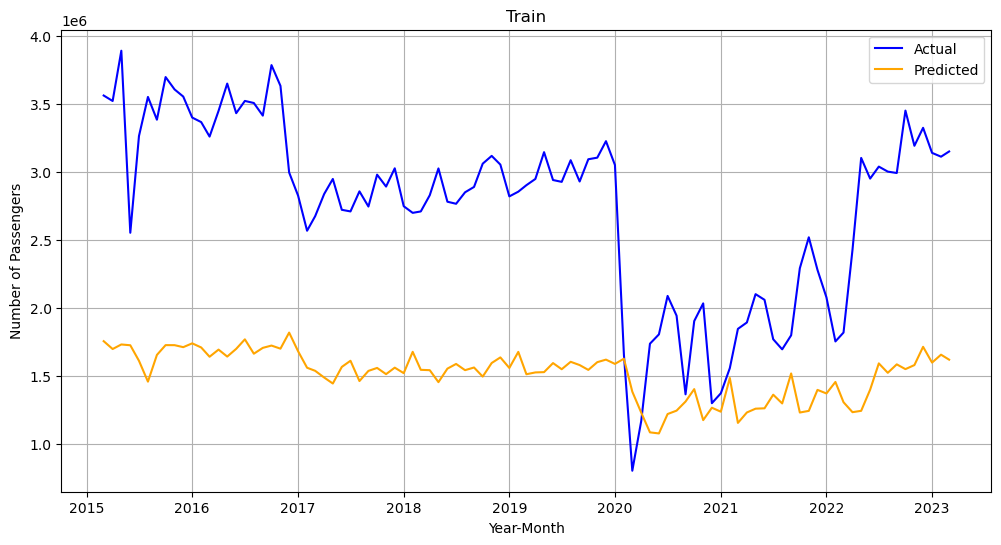

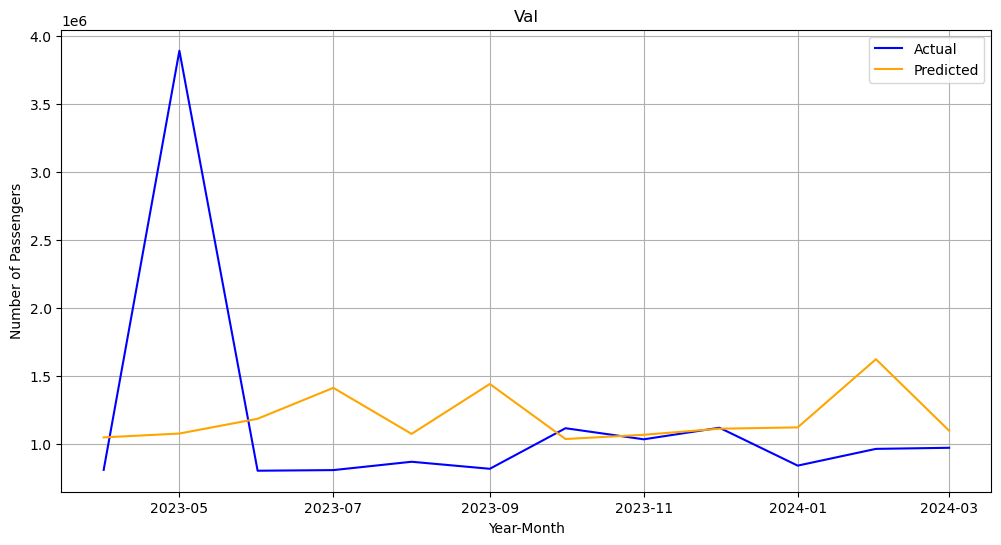

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

def preprocess_for_rnn(X, Y):
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1))

    X_reshaped = X_scaled.reshape((X.shape[0], X.shape[1], 1))
    Y_reshaped = Y_scaled.reshape((Y.shape[0], 1))
    
    return X_reshaped, Y_reshaped, scaler_X, scaler_Y

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(64, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def tune_and_evaluate_rnn(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
    input_shape = (X_train.shape[1], X_train.shape[2])
    rnn_model = create_rnn_model(input_shape)

    history = rnn_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                            validation_data=(X_val, Y_val), verbose=2, 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    Y_train_pred = rnn_model.predict(X_train)
    Y_val_pred = rnn_model.predict(X_val)

    return rnn_model, Y_train_pred, Y_val_pred, history

def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240615.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# 데이터 전처리 (RNN용)
X_train_rnn, Y_train_rnn, scaler_X, scaler_Y = preprocess_for_rnn(X_train_scaled, Y_train)
X_val_rnn, Y_val_rnn, _, _ = preprocess_for_rnn(X_val_scaled, Y_val)

# RNN 모델 평가
best_rnn_model, Y_train_pred_rnn, Y_val_pred_rnn, history_rnn = tune_and_evaluate_rnn(X_train_rnn, Y_train_rnn, X_val_rnn, Y_val_rnn, epochs=100, batch_size=64)

# 역변환 (Inverse Transform)하여 원래 스케일로 변환
Y_train_pred_rnn = scaler_Y.inverse_transform(Y_train_pred_rnn)
Y_val_pred_rnn = scaler_Y.inverse_transform(Y_val_pred_rnn)
Y_train_rnn = scaler_Y.inverse_transform(Y_train_rnn)
Y_val_rnn = scaler_Y.inverse_transform(Y_val_rnn)

# RNN 성능 지표 계산
train_r_squared_rnn = r2_score(Y_train_rnn, Y_train_pred_rnn)
train_mae_rnn = mean_absolute_error(Y_train_rnn, Y_train_pred_rnn)
train_mse_rnn = mean_squared_error(Y_train_rnn, Y_train_pred_rnn)
train_mape_rnn = np.mean(np.abs((Y_train_rnn - Y_train_pred_rnn) / Y_train_rnn)) * 100

val_r_squared_rnn = r2_score(Y_val_rnn, Y_val_pred_rnn)
val_mae_rnn = mean_absolute_error(Y_val_rnn, Y_val_pred_rnn)
val_mse_rnn = mean_squared_error(Y_val_rnn, Y_val_pred_rnn)
val_mape_rnn = np.mean(np.abs((Y_val_rnn - Y_val_pred_rnn) / Y_val_rnn)) * 100

results_rnn = {
    'train_metrics': {
        'r_squared': train_r_squared_rnn,
        'mae': train_mae_rnn,
        'mse': train_mse_rnn,
        'mape': train_mape_rnn
    },
    'val_metrics': {
        'r_squared': val_r_squared_rnn,
        'mae': val_mae_rnn,
        'mse': val_mse_rnn,
        'mape': val_mape_rnn
    }
}

# 결과 출력
print('RNN(Train):')
print(f"R-squared: {results_rnn['train_metrics']['r_squared']:.2f}")
print(f"MAE: {results_rnn['train_metrics']['mae']:.2f}")
print(f"MSE: {results_rnn['train_metrics']['mse']:.2f}")
print(f"MAPE: {results_rnn['train_metrics']['mape']:.2f}%")
print()
print('RNN(Val):')
print(f"R-squared: {results_rnn['val_metrics']['r_squared']:.2f}")
print(f"MAE: {results_rnn['val_metrics']['mae']:.2f}")
print(f"MSE: {results_rnn['val_metrics']['mse']:.2f}")
print(f"MAPE: {results_rnn['val_metrics']['mape']:.2f}%")

# 결과 시각화
plot_results(train_data, val_data, Y_train_rnn, Y_train_pred_rnn, Y_val_rnn, Y_val_pred_rnn)
